# VLB Small-Amplitude Oscillatory Shear (SAOS)

**VLB transient network — SAOS fitting (primary use case)**

## Context: VLB SAOS Response

SAOS is the **primary experimental protocol** for VLB characterization. For a single Maxwell mode:

$$G'(\omega) = G_0 \frac{\omega^2 t_R^2}{1 + \omega^2 t_R^2}, \qquad G''(\omega) = G_0 \frac{\omega t_R}{1 + \omega^2 t_R^2}$$

where $t_R = 1/k_d$. The **crossover frequency** $\omega_c$ where $G' = G''$ gives a direct read of the dissociation rate: $\omega_c = k_d$. At crossover, $G_c = G_0/2$.

**Physical picture:** At low $\omega \ll k_d$, bonds have time to exchange many times per cycle → terminal zone ($G' \sim \omega^2$, $G'' \sim \omega$). At high $\omega \gg k_d$, the network responds elastically → plateau ($G' \to G_0$). The crossover marks the transition from viscous to elastic dominance.

**Cole-Cole plot:** $(G', G'')$ traces a **semicircle** of diameter $G_0$ — the signature of single-exponential Maxwell relaxation. Depressed semicircles indicate multiple relaxation times (VLBMultiNetwork).

> **Handbook:** See [VLB Model Reference](../../docs/source/models/vlb/vlb.rst) for SAOS equations, [VLB Knowledge](../../docs/source/models/vlb/vlb_knowledge.rst) for spectrum interpretation.

## Learning Objectives

- Fit SAOS data ($G'$, $G''$) to extract $G_0$ and $k_d$
- Use the crossover frequency as a direct read of $k_d$
- Compare single-mode vs multi-mode fitting
- Construct Cole-Cole plot as a Maxwell diagnostic

## Estimated Runtime

- ~1 min (analytical)

In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"

In [2]:
%matplotlib inline
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models import VLBLocal, VLBMultiNetwork

jax, jnp = safe_import_jax()
verify_float64()
warnings.filterwarnings("ignore", category=FutureWarning)  # JAX/equinox upstream deprecation churn — not actionable in user notebooks
import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

## 2. Theory

For VLBLocal (single Maxwell mode):

$$G'(\omega) = G_0 \frac{\omega^2 t_R^2}{1 + \omega^2 t_R^2}, \qquad G''(\omega) = G_0 \frac{\omega t_R}{1 + \omega^2 t_R^2}$$

where $t_R = 1/k_d$.

**Key features:**
- **Crossover:** $G'(\omega_c) = G''(\omega_c)$ at $\omega_c = k_d$, with $G_c = G_0/2$
- **Low-$\omega$:** $G' \sim \omega^2$, $G'' \sim \omega$ (terminal zone)
- **High-$\omega$:** $G' \to G_0$, $G'' \sim 1/\omega$ (plateau)
- **Cole-Cole:** $(G', G'')$ traces a semicircle of diameter $G_0$

## 3. Single-Mode SAOS

In [3]:
# Generate synthetic Maxwell SAOS data
np.random.seed(42)
G0_true, kd_true = 5000.0, 2.0
tR = 1.0 / kd_true

omega = np.logspace(-2, 3, 50)
G_prime_true = G0_true * (omega * tR)**2 / (1 + (omega * tR)**2)
G_double_prime_true = G0_true * (omega * tR) / (1 + (omega * tR)**2)
G_star_true = G_prime_true + 1j * G_double_prime_true

# Add noise
noise = 0.03
G_prime_data = G_prime_true * (1 + noise * np.random.randn(len(omega)))
G_double_prime_data = G_double_prime_true * (1 + noise * np.random.randn(len(omega)))
G_star_data = G_prime_data + 1j * G_double_prime_data

In [4]:
# Fit
import time

model = VLBLocal()
t0 = time.time()
model.fit(omega, G_star_data, test_mode="oscillation")
t_fit = time.time() - t0

print(f"Fit time: {t_fit:.2f} s")
print(f"G₀  = {model.G0:.1f} Pa (true: {G0_true})")
print(f"k_d = {model.k_d:.4f} 1/s (true: {kd_true})")
print(f"ω_c = k_d = {model.k_d:.4f} rad/s")
print(f"G_c = G₀/2 = {model.G0/2:.1f} Pa")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.720128s


INFO:nlsq.least_squares:Convergence reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=10 | final_cost=0.0155 | elapsed=0.720s | final_gradient_norm=0.0021


Fit time: 1.02 s
G₀  = 4947.7 Pa (true: 5000.0)
k_d = 1.9735 1/s (true: 2.0)
ω_c = k_d = 1.9735 rad/s
G_c = G₀/2 = 2473.9 Pa


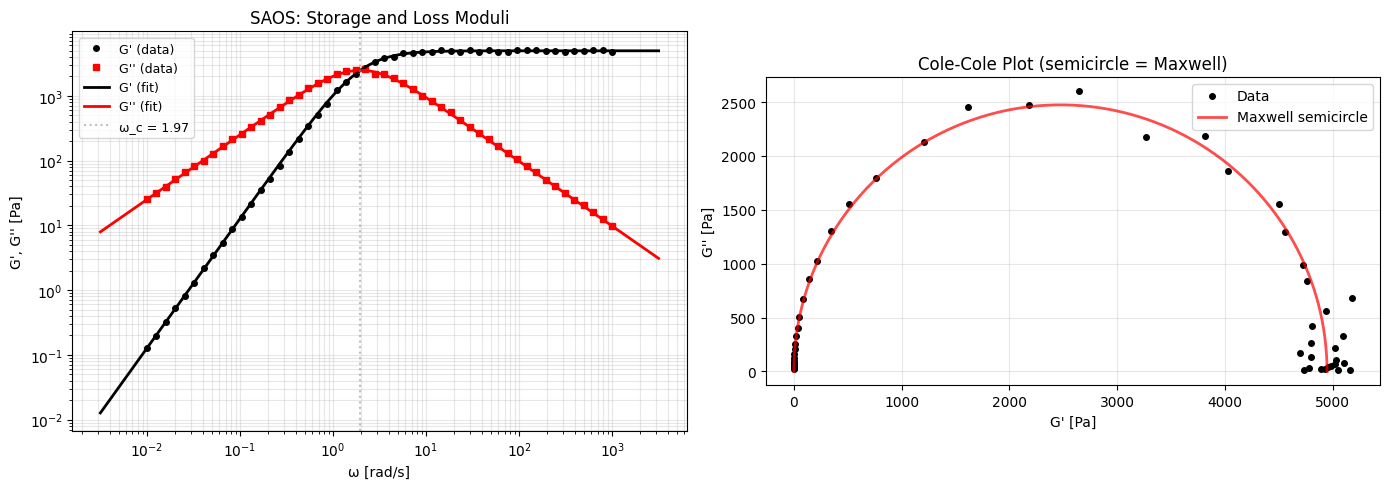

In [5]:
# Predict G', G'' separately using predict_saos
omega_fine = np.logspace(-2.5, 3.5, 200)
G_prime_pred, G_double_prime_pred = model.predict_saos(omega_fine)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# SAOS plot
ax1.loglog(omega, G_prime_data, "ko", markersize=4, label="G' (data)")
ax1.loglog(omega, G_double_prime_data, "rs", markersize=4, label="G'' (data)")
ax1.loglog(omega_fine, G_prime_pred, "k-", lw=2, label="G' (fit)")
ax1.loglog(omega_fine, G_double_prime_pred, "r-", lw=2, label="G'' (fit)")
ax1.axvline(model.k_d, color="gray", linestyle=":", alpha=0.5, label=f"ω_c = {model.k_d:.2f}")
ax1.set_xlabel("ω [rad/s]")
ax1.set_ylabel("G', G'' [Pa]")
ax1.set_title("SAOS: Storage and Loss Moduli")
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3, which="both")

# Cole-Cole plot
theta = np.linspace(0, np.pi, 100)
cc_G_prime = model.G0 / 2 * (1 + np.cos(theta))
cc_G_double_prime = model.G0 / 2 * np.sin(theta)

ax2.plot(G_prime_data, G_double_prime_data, "ko", markersize=4, label="Data")
ax2.plot(cc_G_prime, cc_G_double_prime, "r-", lw=2, alpha=0.7, label="Maxwell semicircle")
ax2.set_xlabel("G' [Pa]")
ax2.set_ylabel("G'' [Pa]")
ax2.set_title("Cole-Cole Plot (semicircle = Maxwell)")
ax2.set_aspect("equal")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 4. Multi-Mode SAOS

For broad spectra, use VLBMultiNetwork.

In [6]:
# Generate 2-mode data with solvent
np.random.seed(42)
G1, kd1 = 3000.0, 0.5   # Slow mode
G2, kd2 = 2000.0, 50.0  # Fast mode
eta_s = 0.1              # Solvent

tR1, tR2 = 1/kd1, 1/kd2
Gp_2mode = (G1 * (omega*tR1)**2 / (1 + (omega*tR1)**2) +
            G2 * (omega*tR2)**2 / (1 + (omega*tR2)**2))
Gdp_2mode = (G1 * omega*tR1 / (1 + (omega*tR1)**2) +
             G2 * omega*tR2 / (1 + (omega*tR2)**2) + eta_s * omega)
G_star_2mode = Gp_2mode * (1 + 0.02 * np.random.randn(len(omega))) + \
    1j * Gdp_2mode * (1 + 0.02 * np.random.randn(len(omega)))

# Fit
model_multi = VLBMultiNetwork(n_modes=2)
model_multi.fit(omega, G_star_2mode, test_mode="oscillation")

print("Fitted spectrum:")
for i, (Gi, tRi) in enumerate(model_multi.get_relaxation_spectrum()):
    print(f"  Mode {i}: G = {Gi:.0f} Pa, k_d = {1/tRi:.2f} 1/s")
print(f"  η_s = {model_multi.eta_s:.4f} Pa·s")
print(f"  η₀ = {model_multi.eta_0:.1f} Pa·s")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=5 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.988852s


INFO:nlsq.least_squares:Convergence reason=`gtol` termination condition is satisfied. | iterations=12 | final_cost=0.0066 | elapsed=0.989s | final_gradient_norm=6.6822e-07


Fitted spectrum:
  Mode 0: G = 2988 Pa, k_d = 0.50 1/s
  Mode 1: G = 1977 Pa, k_d = 50.37 1/s
  η_s = 0.0003 Pa·s
  η₀ = 6038.9 Pa·s


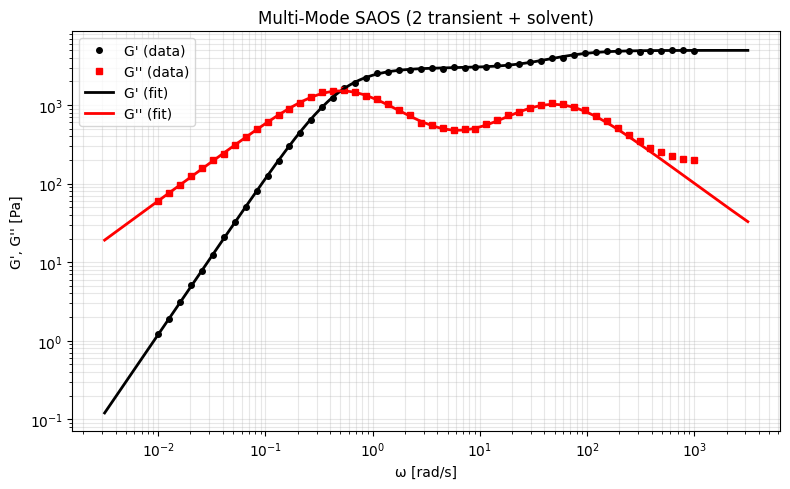

In [7]:
Gp_multi, Gdp_multi = model_multi.predict_saos(omega_fine)

fig, ax = plt.subplots(figsize=(8, 5))
ax.loglog(omega, np.real(G_star_2mode), "ko", markersize=4, label="G' (data)")
ax.loglog(omega, np.imag(G_star_2mode), "rs", markersize=4, label="G'' (data)")
ax.loglog(omega_fine, Gp_multi, "k-", lw=2, label="G' (fit)")
ax.loglog(omega_fine, Gdp_multi, "r-", lw=2, label="G'' (fit)")
ax.set_xlabel("ω [rad/s]")
ax.set_ylabel("G', G'' [Pa]")
ax.set_title("Multi-Mode SAOS (2 transient + solvent)")
ax.legend()
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Save Results

In [8]:
import json
import os

output_dir = os.path.join("..", "outputs", "vlb", "saos")
os.makedirs(output_dir, exist_ok=True)

params = {"G0": float(model.G0), "k_d": float(model.k_d)}
with open(os.path.join(output_dir, "nlsq_params.json"), "w") as f:
    json.dump(params, f, indent=2)

print(f"Saved to {output_dir}/")

Saved to ../outputs/vlb/saos/


## Key Takeaways

1. **SAOS is the primary fitting target** for VLB — broadest frequency window
2. **Crossover frequency = $k_d$** gives dissociation rate directly
3. **Cole-Cole semicircle** is a Maxwell diagnostic — deviations indicate multiple modes
4. **Multi-mode** resolves broad spectra with multiple bond populations

## Further Reading

- [VLB Model Reference](../../docs/source/models/vlb/vlb.rst) — SAOS analytical solutions, multi-network formulation
- [VLB Knowledge Extraction](../../docs/source/models/vlb/vlb_knowledge.rst) — SAOS diagnostics, spectrum analysis, crossover validation
- Vernerey, F.J., Long, R. & Brighenti, R. (2017). *J. Mech. Phys. Solids*, 107, 1-20.

## Next Steps

- **Notebook 06**: LAOS simulation (linear $\sigma_{12}$ + $N_1$ harmonics)
- **Notebook 07**: Full Bayesian workflow on SAOS data